In [2]:
# Adapted from: https://kozodoi.me/blog/20210308/compute-image-stats


In [5]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/f8/7f/5b047effafbdd34e52c9e2d7e44f729a0655efafb22198c45cf692cdc157/pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 3.0 MB/s eta 0:00:002.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.7 MB/s eta 0:00:00m eta 0:00:010:01:01


In [1]:
import glob
import os

import torch 
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import torchvision

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
Image.MAX_IMAGE_PIXELS = None


class MillionAID(Dataset):
    def __init__(self, root, transforms=None):
        images = list(glob.glob(os.path.join(root, "test", "*", "*.jpg")))
        self.transform = transforms
        self.files = images

        print('Creating MillionAID dataset with {} examples'.format(len(self.files)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img_path = self.files[i]
        img = Image.open(img_path).convert('RGB')
        print(np.array(img).shape)
        img = self.transform(img)
        return img

def build_NWPU_RESISC(DATA_PATH, transforms):
    dataset = torchvision.datasets.ImageFolder(root=DATA_PATH)
    train_size, test_size = int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))
    dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_train.dataset.transform = transforms
    return dataset_train , dataset_test

In [56]:
import glob
import os
from typing import Callable, Optional

import torchvision.datasets as datasets
import pandas as pd
from PIL import Image
from tqdm import tqdm

class CXRDataset(datasets.VisionDataset):
    def __init__(self,
                 root: str,
                 is_train: bool,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None
                 ):
        super().__init__(
            root,
            transform=transform,
            target_transform=target_transform
        )
        self.is_train = is_train
        self.num_classes = 15
        self.class_list = ["Atelectasis", "Cardiomegaly", "Effusion",
                           "Infiltration", "Mass", "Nodule", "Pneumonia",
                           "Pneumothorax", "Consolidation", "Edema",
                           "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia",
                           "No Finding"]
        self.root = root
        
        self.images = list(glob.glob(os.path.join(root, "*", "*", "*.png")))
        self.samples, self.labels = self.make_dataset()
        print(len(self.samples))

    def __getitem__(self, item):
        img_path = self.samples[item] 
        img = Image.open(img_path).convert('RGB')
       
        img = self.transform(img)
        lbls = self.labels[item]
        return img

    def __len__(self):
        return len(self.samples)

    def make_dataset(self):
        samples = []
        labels = []
        trainval_list = f"{self.root}/train_val_list.txt" if self.is_train else f"{self.root}/test_list.txt"
        files = open(trainval_list,'r').read().split('\n')
        metadata = pd.read_csv(f"{self.root}/Data_Entry_2017_v2020.csv")
        metadata = dict(zip(metadata["Image Index"], metadata["Finding Labels"]))
        for img in tqdm(self.images):
            filename = img.split("/")[-1]
            if filename in files:
                samples.append(img)
                label = metadata[filename].split("|")
                sample_labels = [x in label for x in self.class_list]
              
                sample_labels = np.int32(sample_labels)
                assert sample_labels.sum() > 0 and sample_labels.sum() == len(label)
                labels.append(sample_labels)
                 
        return samples, labels


In [25]:
transformat = transforms.Compose([transforms.Resize((224, 224)), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean = (0), std  = (1))])

In [57]:
DATA_PATH = "../datasets/CXR"
BATCH_SIZE = 8
NUM_WORKERS = 8

dataset_train = CXRDataset(DATA_PATH, transform=transformat, is_train=True)
#dataset_train, dataset_test = build_NWPU_RESISC(DATA_PATH_NWPU, transformat)
print(dataset_train)
data_loader = torch.utils.data.DataLoader(
        dataset_train, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True)

 36%|████████████▎                     | 40614/112120 [00:20<00:35, 2009.52it/s]


KeyboardInterrupt: 

In [34]:
len(dataset_train.samples)

25596

In [46]:
mean_final = mean_1 / len(dataset_train)

In [47]:
mean_final

tensor([  3.0000, 499.7591, 499.7591])

In [36]:
import copy
for batch_idx, inputs in enumerate(data_loader):
    print(inputs)
    batch_cp = copy.deepcopy(inputs)
    del inputs

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tonio/anaconda3/envs/ssl-nogeo/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tonio/anaconda3/envs/ssl-nogeo/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/tonio/anaconda3/envs/ssl-nogeo/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 371, 371] at entry 0 and [3, 408, 408] at entry 1


2
torch.Size([8, 3, 224, 224])


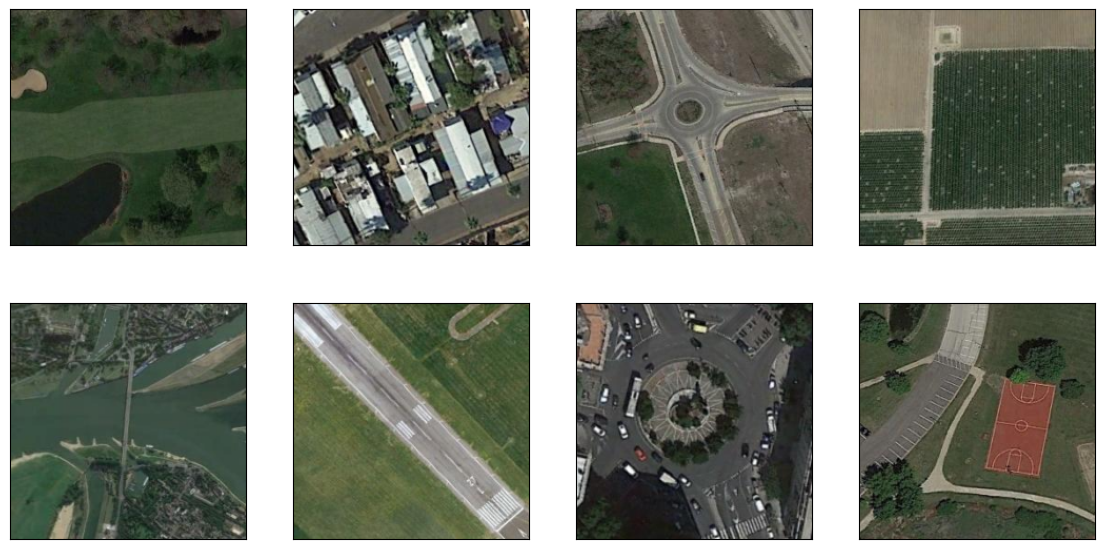

In [56]:
for batch_idx, inputs in enumerate(data_loader):
    print(len(inputs))
    print(inputs[0].shape)
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break

In [15]:
res = Image.open('../datasets/CXR/images_008/images/00017199_012.png')

In [29]:
(inputs ** 2).sum(axis = [0, 2, 3])

tensor([99957.2422])

In [37]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for inputs in tqdm(data_loader):
    psum    += inputs.sum(axis = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|█████████████████████████████████████| 10816/10816 [02:19<00:00, 77.78it/s]


In [48]:
img = Image.open('../datasets/CXR/images_008/images/00017138_111.png').convert('RGB')

In [50]:
img = np.array(img)
img.shape
print(img[:, :, 0].mean())
print(img[:, :, 1].mean())
print(img[:, :, 2].mean())

121.35866832733154
121.35866832733154
121.35866832733154


In [52]:
torch.mean(transforms.ToTensor()(img))

tensor(0.4759)

In [38]:
pixel_count = len(dataset_train) * 224 * 224
total_mean = psum / pixel_count
total_var  = (psum_sq / pixel_count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

print(f"Mean: {total_mean} and Standard Deviation: {total_std}")

Mean: tensor([0.5057, 0.5057, 0.5057]) and Standard Deviation: tensor([0.2508, 0.2508, 0.2508])


In [ ]:
len(dataset_train)

In [ ]:
psum_sq

In [ ]:
for inputs in tqdm(data_loader):
    print(inputs.shape)

  0%|                                                  | 0/3200 [00:00<?, ?it/s]